<a href="https://colab.research.google.com/github/jessicasalazar/vision_computador/blob/main/Taller_2_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop #2
1. Conduct an exploration of the dataset.
2. Extract features using a pre-trained model (ResNet-50, MobileNet, ...), and train the classification head (recommended: AutoGluon).
4. Evaluate the model’s performance.

In [1]:
# Import libraries required
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import top_k_accuracy_score

In [2]:
# Setting access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Conduct an exploration of the dataset.

### DATASET DESCRIPTION: The LabelMe-12-50K

The LabelMe-12-50k dataset comprises 50,000 images, with 40,000 for training and 10,000 for testing. Each image is 256 x 256 pixels in size. The images are classified into one of 12 classes.

The dataset contains two types of files named annotations: the first is annotation.txt, which contains the image file name and the corresponding class label; the second is annotation.bin, which contains 12 successive 32-bit float values for each image, representing the class label of the corresponding class. Those annotation files are available for training and testing.

50% of the images in the training and test sets are not classified into the 12 classes; instead, they are categorized as clutter, which represents other classes. Furthermore, the error rates are as follows, and in the table below, we show the images classified for each class.

| Method used                      | Training error rate | Testing error rate |
|----------------------------------|---------------------|--------------------|
| Locally-connected Neural Pyramid | 3.77%               | 16.27%             |


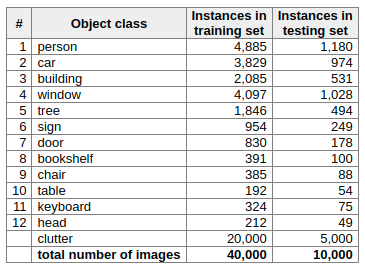

In [3]:
# Display an image of the table with the total number of images within each class
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/02_Clasificacion/LabelMe_classes.png'))

In [4]:
# Download the images
!wget -qO- https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz | tar -xz -C /content/

In [5]:
def load_split_from_bin_with_classes(data_dir, split, atol=1e-6):
  """
  Create labels corresponding to the class of each image.

  Args:
      data_dir (str): The path of this directory.
      split (str): The phase that is train or test.
      atol (float): The error level.

  Returns:
      df (dataframe): Dataframe with the address directory and name of image, and with the class label.
  """

  # Define the path for dataset
  classes_txt_path = os.path.join(data_dir, "classes.txt")
  txt_path = os.path.join(data_dir, split, "annotation.txt")
  bin_path = os.path.join(data_dir, split, "annotation.bin")

  # Open data about classes
  with open(classes_txt_path, encoding="utf-8") as f:
      classes = [x.strip() for x in f if x.strip()]
  if len(classes) != 12:
    raise ValueError(f"Se esperaban 12 clases en '{classes_txt_path}', hay {len(classes)}.")
  else:
    print(f"Las categorías totales son: {len(classes)}")

  # Create the extra class, it is "clutter" and represent the 50% of the images
  classes_plus = classes + ["clutter"]

  # Read the file named "annotation.txt" to create the name of image and link with the label correspondig to the class
  df_txt = pd.read_csv(txt_path, sep=r"\s+", header=None, dtype={0: str}, engine="python")
  df_txt

  # Verify the IDs column in annotation.txt
  if df_txt.shape[1] < 1:
      raise ValueError(f"'{txt_path}' no tiene columna de IDs.")
  ids = df_txt.iloc[:, 0].to_numpy()

  # Create the route for each image in this project
  images = [os.path.join(data_dir, split, '0'+i[0:3], i[-6:]+'.jpg') for i in ids]

  # Read the bin file
  raw = np.fromfile(bin_path, dtype=np.float32)

  # Verify the size of the matrix, should be 12
  if raw.size % 12 != 0:
      raise ValueError(f"El binario '{bin_path}' no tiene múltiplo de 12 columnas (size={raw.size}).")

  # Reshape from vector to matrix
  scores = raw.reshape(-1, 12)

  # Clasify each image within the corresponding class
  is_one = np.isclose(scores, 1.0, atol=atol)
  has_obj = is_one.any(axis=1)
  first_one = is_one.argmax(axis=1)
  int_label = np.where(has_obj, first_one, 12)
  str_label = [classes_plus[i] for i in int_label]

  # Create the final dataset
  df = pd.DataFrame({
      "image": images,
      "label": int_label
      })
  df = df[df["label"]!=12]
  return df

In [6]:
# Call function load_split_from_bin_with_classes
DATA_DIR = "/content"
train_df= load_split_from_bin_with_classes(DATA_DIR, "train")
test_df = load_split_from_bin_with_classes(DATA_DIR, "test")

# Transform label variable type in category
train_df.label = train_df.label.astype("category")
test_df.label = test_df.label.astype("category")

Las categorías totales son: 12
Las categorías totales son: 12


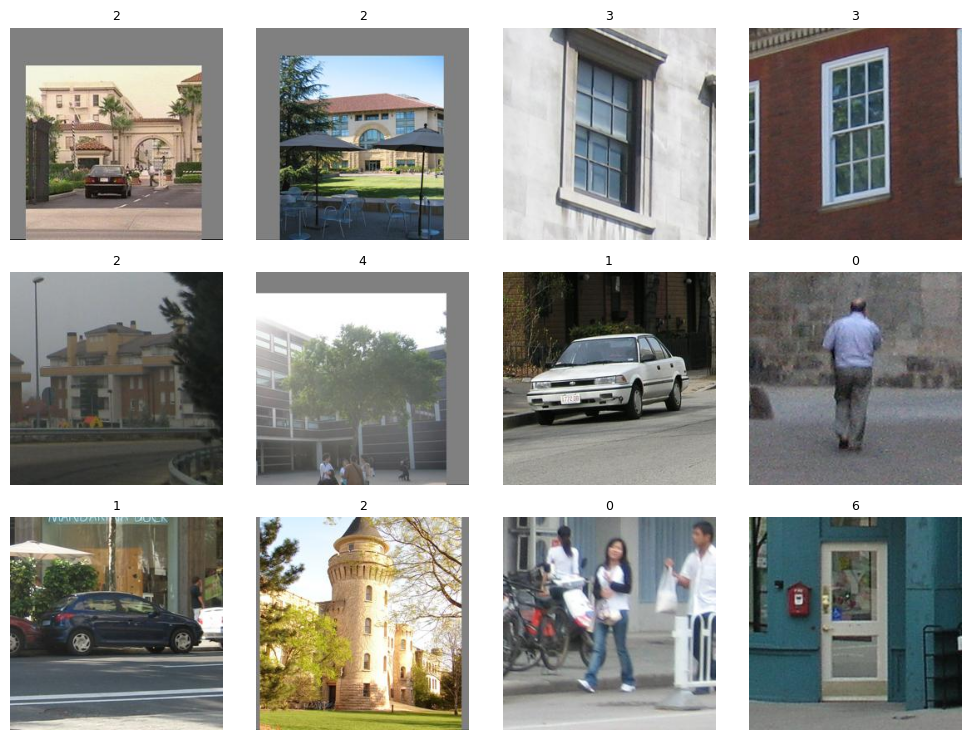

In [7]:
def ver_grid(df, n=12, cols=4):
    """
    Plot a sample of images with the number of its label class.

    Args:
        df (dataframe): Dataframe with the address directory and name of image, and with class label.
        n (int): Number of images to plot.
        cols (int): Total of images in columns.

    Returns:
        plot: Plot of images
    """

    # Select the sample of images
    sel = df.sample(n=min(n, len(df))).reset_index(drop=True)
    rows = math.ceil(len(sel) / cols)

    # Configuration of plots
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    axes = axes.ravel() if rows*cols > 1 else [axes]

    # Labels of images
    for i, row in sel.iterrows():
        ax = axes[i]
        ax.imshow(plt.imread(row["image"]))
        ax.set_title(str(row["label"]), fontsize=9)
        ax.axis("off")

    # Without axes of plots
    for j in range(len(sel), len(axes)):
        axes[j].axis("off")

    # Display plot
    plt.tight_layout()
    plt.show()

# Call function ver_grid
ver_grid(train_df)

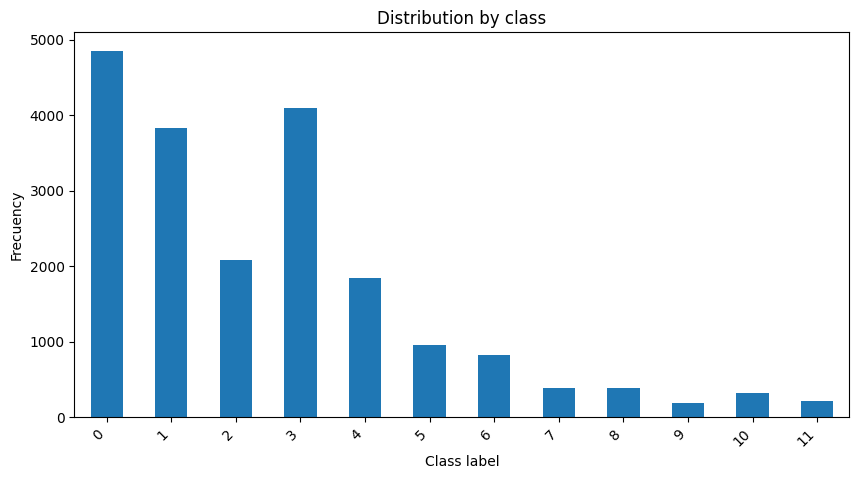

In [8]:
def plot_bar(kind):
  """
  Graph of distribution by class.

  Args:
      kind (str): Type of graph.

  Returns:
      plot: Plot of classes distribution.

  """
  counts = train_df["label"].value_counts().sort_index()
  fig = plt.figure(figsize=(10, 5))
  counts.plot(kind=kind)
  plt.title("Distribution by class")
  plt.xlabel("Class label")
  plt.ylabel("Frecuency")
  plt.xticks(rotation=45, ha="right")

# Call function plot_bar
plot_bar("bar")

In [9]:
def var_eda(df_splits, max_per_class=0):
  """
  Create variables related with pixels of each channels.

  Args:
      df_splits (dataframe): List of dataframes with images.
      max_per_class (int): Maximum per class existent.

  Returns:
      feats_all (dataframe): Dataframe with columns created.
  """

  # Execute to train and then to test
  feats_all = []
  for split in df_splits:
      df = split
      by_class = Counter()
      rows = []

      for _, r in df.iterrows():
          lbl = r["label"]
          if max_per_class > 0 and by_class[lbl] >= max_per_class:
              continue

          path = r["image"]

          # Create new variables for each band
          try:
              with Image.open(path) as im:
                  im = im.convert("RGB")
                  w, h = im.size
                  arr = np.asarray(im, dtype=np.float32)
                  mean_r = float(arr[:, :, 0].mean())
                  mean_g = float(arr[:, :, 1].mean())
                  mean_b = float(arr[:, :, 2].mean())
                  brightness = float(arr.mean())

              rows.append({
                  "image": path,
                  "str_label": lbl,
                  "width": w,
                  "height": h,
                  "area": int(w) * int(h),
                  "aspect_ratio": (w / h) if h else np.nan,
                  "mean_r": mean_r,
                  "mean_g": mean_g,
                  "mean_b": mean_b,
                  "brightness": brightness,
                  "split": split,
              })
              by_class[lbl] += 1
          except Exception:
              continue

      # Create dataframe with new variables
      feats = pd.DataFrame(rows)
      feats_all.append(feats)

  # Concat new variables of train and test to dataframe
  feats_all = pd.concat(feats_all, ignore_index=True) if feats_all else pd.DataFrame()

  return feats_all

# Call var_eda function
feats = var_eda(df_splits=[train_df,test_df], max_per_class=12)

/tmp/ipython-input-10-3501116608.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


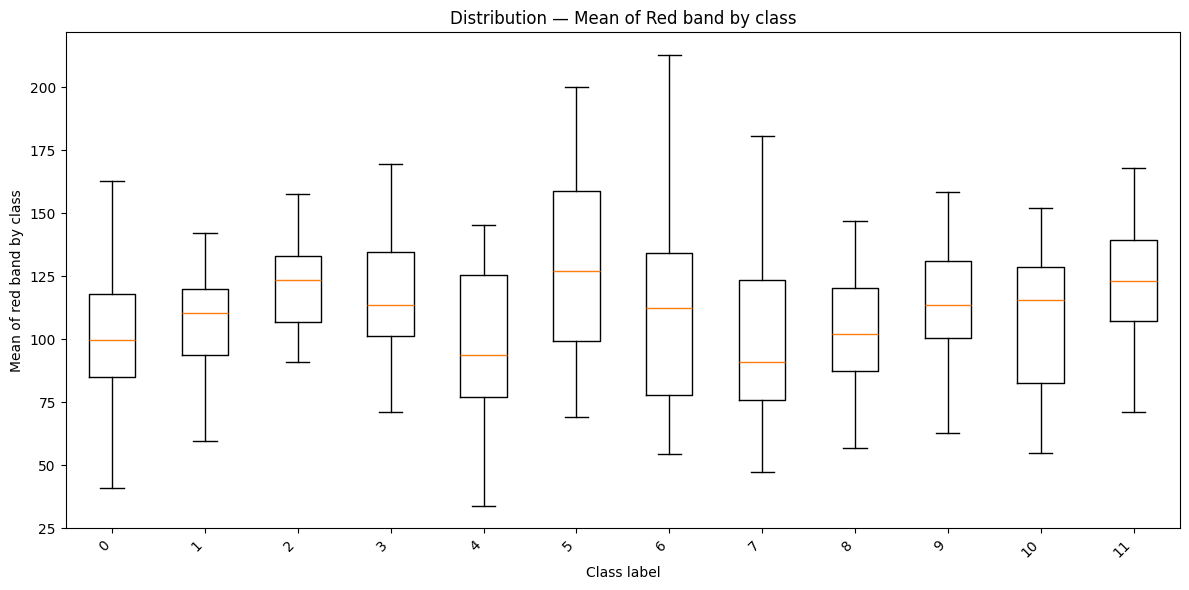

/tmp/ipython-input-10-3501116608.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


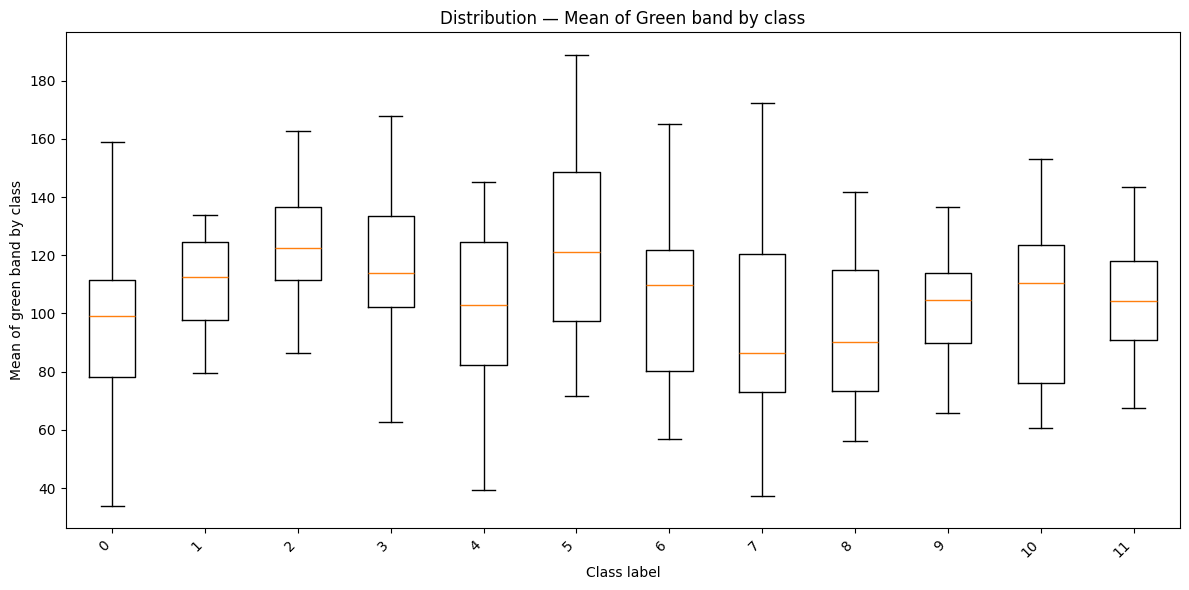

/tmp/ipython-input-10-3501116608.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


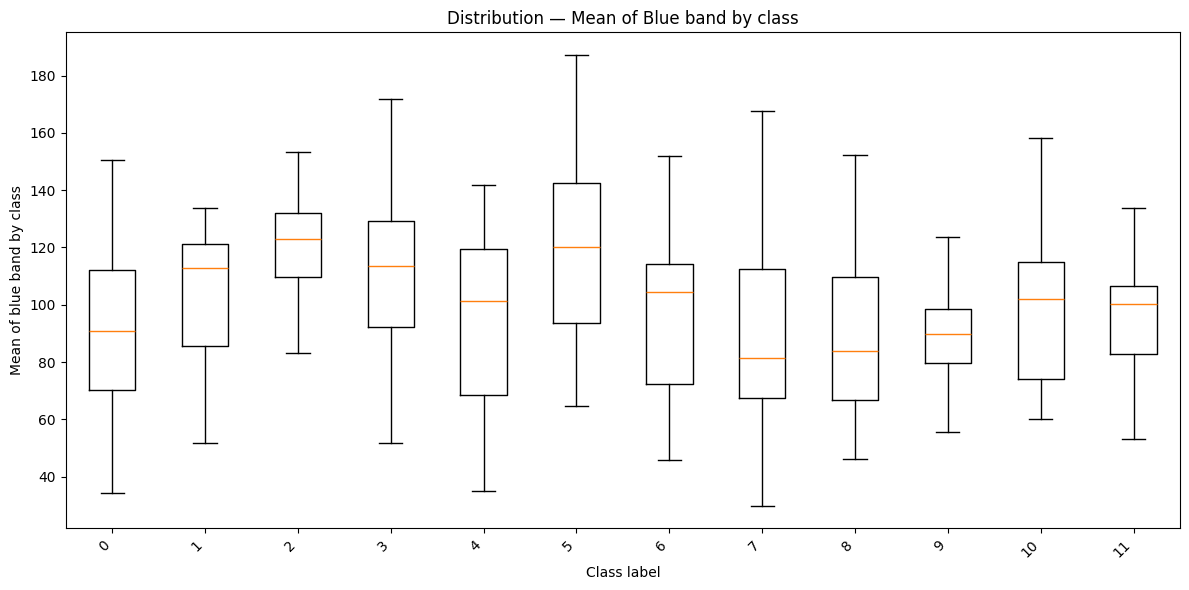

/tmp/ipython-input-10-3501116608.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


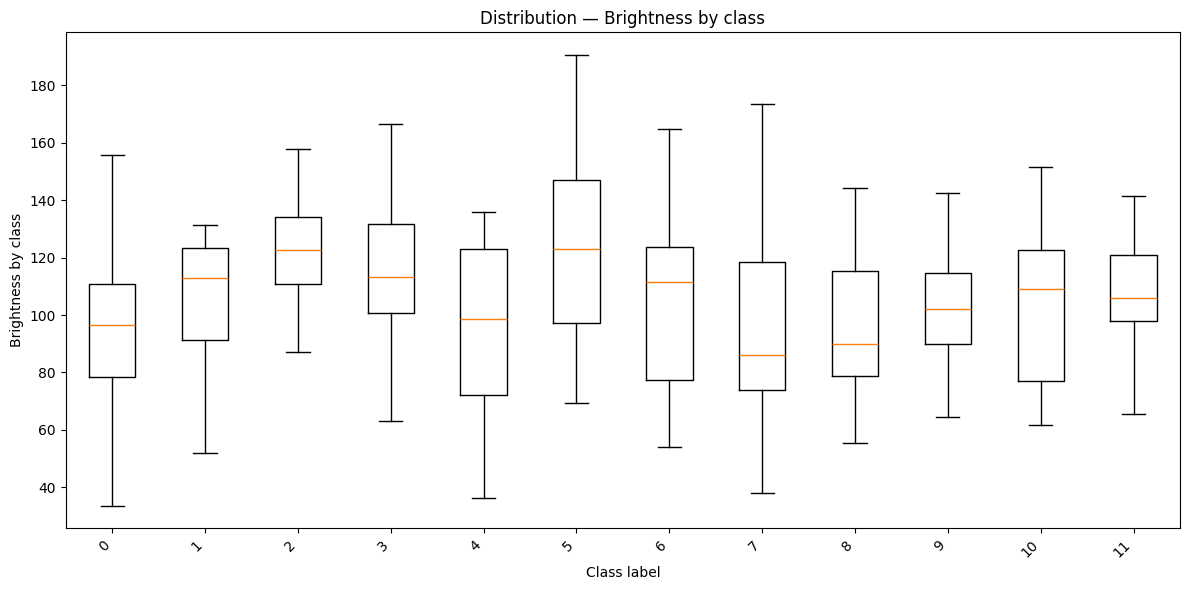

In [10]:
from PIL import Image
# Call var_eda function
feats = var_eda(df_splits=[train_df,test_df], max_per_class=12)

def plot_bigo(feats_all, value_col, var_name):
  """
  Boxplot.

  Args:
      feats_all (dataframe): Dataframe with variables.
      value_col (str): Variable to plot.
      var_name (str): Name to title.

  Returns:
      plot: Boxplot
  """
  order = sorted(feats_all["str_label"].dropna().unique().tolist())
  data = [feats_all.loc[feats_all["str_label"] == c, value_col].dropna().values for c in order]
  plt.figure(figsize=(12, 6))
  plt.boxplot(data, labels=order, showfliers=False)
  plt.title(f"Distribution — {var_name}")
  plt.xlabel("Class label")
  plt.ylabel(var_name.capitalize())
  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

plot_bigo(feats_all=feats, value_col="mean_r", var_name="Mean of Red band by class")
plot_bigo(feats_all=feats, value_col="mean_g", var_name="Mean of Green band by class")
plot_bigo(feats_all=feats, value_col="mean_b", var_name="Mean of Blue band by class")
plot_bigo(feats_all=feats, value_col="brightness", var_name="Brightness by class")

Text(0.5, 1.0, 'KDE (filled)')

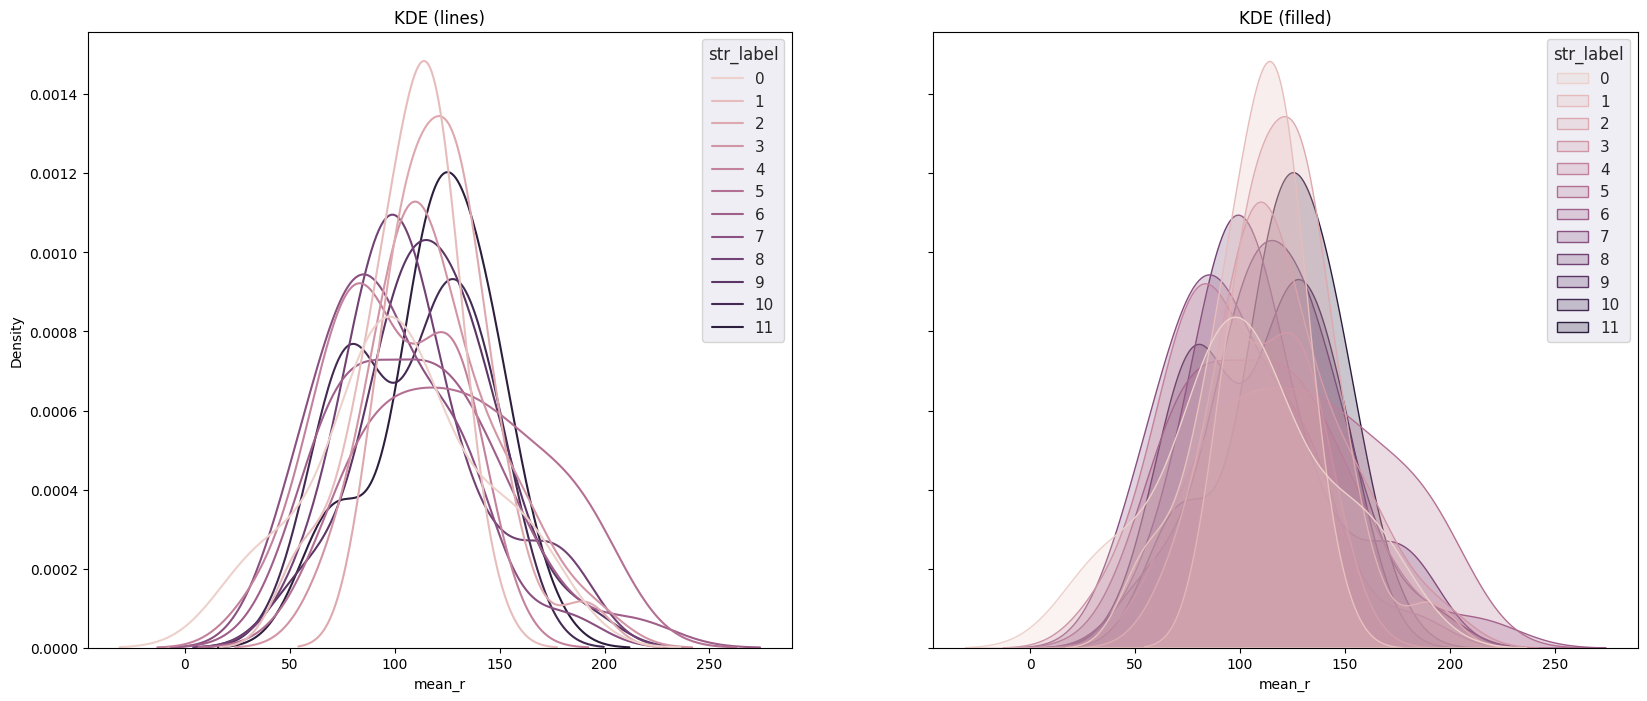

In [11]:
# Density for each band
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)
sns.set_theme()
sns.kdeplot(data=feats, x="mean_r", hue="str_label", ax=axes[0])
axes[0].set_title("KDE (lines)")
sns.kdeplot(data=feats, x="mean_r", hue="str_label", fill=True, ax=axes[1])
axes[1].set_title("KDE (filled)")


# 2. Extract features using a pre-trained model (ResNet-50, MobileNet, ...), and train the classification head (recommended: AutoGluon).

In [12]:
# Install autogluon in colab
! pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━

In [13]:
# Import requirements of autogluon
from autogluon.multimodal import MultiModalPredictor

In [14]:
# Split dataset to train and validation to training phase
df_train, df_val = train_test_split(train_df, test_size=0.20, stratify=train_df["label"], random_state=42)


In [ ]:
# Define the MultiModalPredictor model from Autogluon
predictor = MultiModalPredictor(problem_type="multiclass", label='label')

In [ ]:
# Define hyperparameters. We define resnet50 for extracting features, here.
hparams = {
    "model.names" : ["timm_image"],
    "model.timm_image.checkpoint_name": "resnet50",
    "optim.lr_choice": "two_stages",
    "optim.lr_mult": 50,
    "optim.lr": 1e-4,
    "optim.max_epochs": 5,
    "optim.patience": 5
}

In [ ]:
# Fit the model with autogluon in the head.
predictor.fit(
    hyperparameters = hparams,
    presets = "medium_quality",
    train_data = df_train,
    tuning_data = df_val
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251013_144418"
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Count:          1
Memory Avail:       7.18 GB / 12.67 GB (56.7%)
Disk Space Avail:   26.20 GB / 73.59 GB (35.6%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/AutogluonModels/ag-20251013_144418
    ```

INFO: Seed set to 0
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your 

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name              | Type                            | Params | Mode 
------------------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 23.5 M | train
1 | validation_metric | MulticlassAccuracy              | 0      | train
2 | loss_func         | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------------------
23.5 M    Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 62: 'val_accuracy' reached 0.78225 (best 0.78225), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=0-step=62.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 125: 'val_accuracy' reached 0.87250 (best 0.87250), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=0-step=125.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 187: 'val_accuracy' reached 0.89225 (best 0.89225), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=1-step=187.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 250: 'val_accuracy' reached 0.90625 (best 0.90625), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=1-step=250.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 312: 'val_accuracy' reached 0.91125 (best 0.91125), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=2-step=312.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 375: 'val_accuracy' reached 0.91925 (best 0.91925), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=2-step=375.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 437: 'val_accuracy' reached 0.91825 (best 0.91925), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=3-step=437.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 500: 'val_accuracy' reached 0.92225 (best 0.92225), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=3-step=500.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 562: 'val_accuracy' reached 0.92450 (best 0.92450), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=4-step=562.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 625: 'val_accuracy' reached 0.92350 (best 0.92450), saving model to '/content/AutogluonModels/ag-20251013_144418/epoch=4-step=625.ckpt' as top 3
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20251013_144418")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [ ]:
# Guarda todo el predictor en disco (devuelve la ruta donde quedó)
save_dir = predictor.save("/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/predictor")
print("Guardado en:", save_dir)

# (Opcional) ver la ruta interna donde ya se estuvo guardando durante el fit
print("Ruta del predictor:", predictor.path)

Guardado en: None
Ruta del predictor: /content/AutogluonModels/ag-20251013_144418


In [15]:
predictor = MultiModalPredictor().load("/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/predictor")

Load pretrained checkpoint: /content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/predictor/model.ckpt


In [16]:
# 3) Extraer embeddings del backbone (sin la cabeza)
def embed(df):
    # df SOLO con la(s) columna(s) de entrada (image). Sin la etiqueta.
    E = predictor.extract_embedding(df[["image"]])
    cols = [f"f{i}" for i in range(E.shape[1])]
    return pd.DataFrame(E, columns=cols)

X_train = embed(train_df)
y_train = train_df["label"]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
X_val = embed(df_val)
y_val= df_val["label"]
val_tab = X_val.copy()
val_tab["label"] = y_val.values

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
from autogluon.tabular import TabularPredictor
# 4) Reentrenar la cabeza como un clasificador tabular sobre los embeddings
train_tab = X_train.copy()
train_tab["label"] = y_train.values

In [ ]:
head = TabularPredictor(problem_type="multiclass", label="label",  path='/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/head')
head.fit(
    train_data=train_tab,
    tuning_data = val_tab,
    time_limit=3600,
    presets="medium_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251013_150213"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Memory Avail:       5.94 GB / 12.67 GB (46.9%)
Disk Space Avail:   25.82 GB / 73.59 GB (35.1%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/AutogluonModels/ag-20251013_150213"
Train Data Rows:    20000
Train Data Columns: 2048
Tuning Data Rows:    4000
Tuning Data Columns: 2048
Label Column:       label
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 12
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Me

In [ ]:
# import os, shutil

# src = '/content/AutogluonModels/ag-20251013_150213'                                   # origen
# dst_dir = '/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/head'                  # directorio destino
# os.makedirs(dst_dir, exist_ok=True)
# shutil.move(src, dst_dir)


'/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/head/ag-20251013_150213'

In [19]:
head = TabularPredictor.load("/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/Taller_2/head")

In [20]:
# 5) Inferencia con la nueva cabeza
def predict_images(paths):
    df = pd.DataFrame({"image": paths})
    X = embed(df)
    return head.predict_proba(X)  # o head.predict(X)

In [21]:
# Evaluate with validation data
head.evaluate(val_tab)

{'accuracy': 1.0, 'balanced_accuracy': np.float64(1.0), 'mcc': np.float64(1.0)}

In [22]:
X_test = embed(test_df)
y_test= test_df["label"]
test_tab = X_test.copy()
test_tab["label"] = y_test.values

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
# Evaluate with test data
head.evaluate(test_tab)

{'accuracy': 0.8926,
 'balanced_accuracy': np.float64(0.7800954367228883),
 'mcc': np.float64(0.8718486269628751)}

In [26]:
# True Y, prediction and prob
y_true = test_tab['label']
y_pred = head.predict(test_tab).squeeze().astype('category')
proba_df = head.predict_proba(test_tab)

# Equal classes between
classes = list(proba_df.columns)

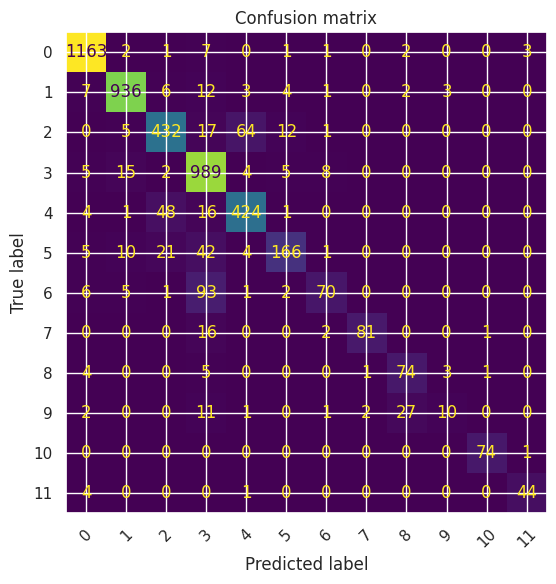

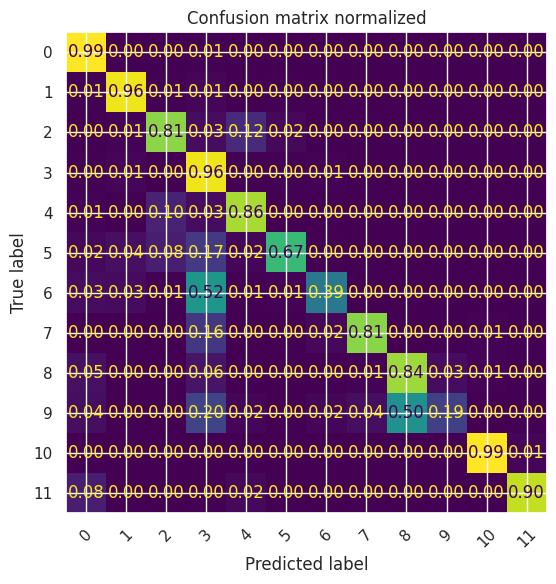

In [27]:
# Plot of confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(ax=ax, xticks_rotation=45, colorbar=False)
ax.set_title("Confusion matrix")
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes).plot(
    ax=ax, xticks_rotation=45, values_format=".2f", colorbar=False
)
ax.set_title("Confusion matrix normalized")
plt.tight_layout()
plt.show()

In [28]:
# Performance metrics by class
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.969167,0.985593,0.977311,1180.0000
1,0.960986,0.960986,0.960986,974.0000
2,0.845401,0.813559,0.829175,531.0000
3,0.818709,0.962062,0.884615,1028.0000
4,0.844622,0.858300,0.851406,494.0000
5,0.869110,0.666667,0.754545,249.0000
6,0.823529,0.393258,0.532319,178.0000
7,0.964286,0.810000,0.880435,100.0000
8,0.704762,0.840909,0.766839,88.0000
9,0.625000,0.185185,0.285714,54.0000


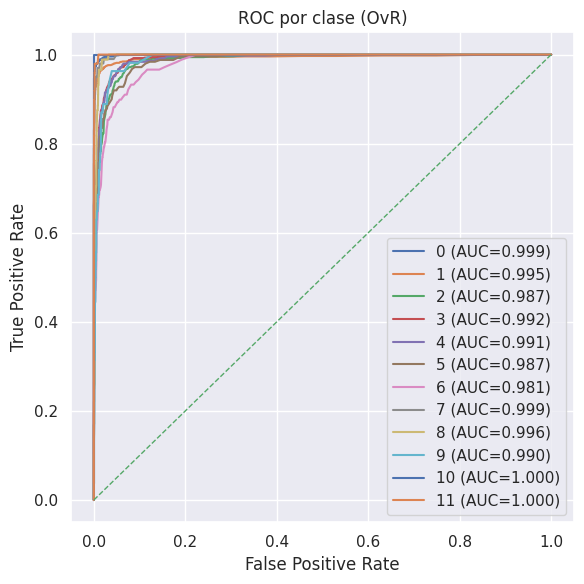

AUC macro: 0.9930 | AUC micro: 0.9954


In [29]:
y_true_bin = label_binarize(y_true, classes=classes)
y_score = proba_df[classes].values  # Asegurar orden

# ROC by class
fig = plt.figure(figsize=(6,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC por clase (OvR)")
plt.legend()
plt.tight_layout()
plt.show()

# AUC
auc_macro = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")
auc_micro = roc_auc_score(y_true_bin, y_score, average="micro", multi_class="ovr")
print(f"AUC macro: {auc_macro:.4f} | AUC micro: {auc_micro:.4f}")


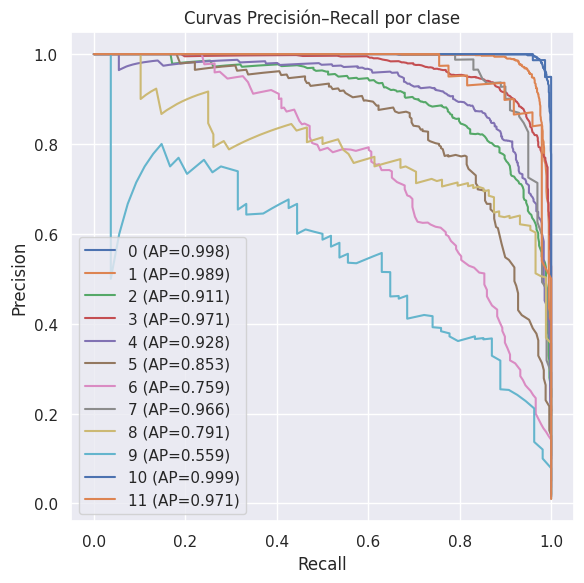

In [30]:
fig = plt.figure(figsize=(6,6))
for i, cls in enumerate(classes):
    prec, rec, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(rec, prec, label=f"{cls} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precisión–Recall por clase")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
for k in (1, 3, 5):
    if k <= len(classes):
        tk = top_k_accuracy_score(y_true, y_score, k=k, labels=classes)
        print(f"Top-{k} accuracy: {tk:.4f}")


Top-1 accuracy: 0.8926
Top-3 accuracy: 0.9848
Top-5 accuracy: 0.9952


In [32]:
cm_off = cm.copy().astype(int)
np.fill_diagonal(cm_off, 0)
pairs = [(classes[i], classes[j], cm_off[i, j])
         for i in range(len(classes)) for j in range(len(classes)) if i != j and cm_off[i, j] > 0]
pd.DataFrame(sorted(pairs, key=lambda x: x[2], reverse=True)[:10],
             columns=["Verdadero", "Predicho", "Conteos"])


,Verdadero,Predicho,Conteos
0,6,3,93
1,2,4,64
2,4,2,48
3,5,3,42
4,9,8,27
5,5,2,21
6,2,3,17
7,4,3,16
8,7,3,16
9,3,1,15
